In [270]:
# Импорты и базовые настройки эксперимента.

# - Фиксируем RANDOM_STATE, чтобы случайные компоненты были воспроизводимыми.
# - Создаём папку artifacts/ – туда будем складывать результаты и модель.

from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve, 
    average_precision_score
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    StackingClassifier,
)
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: C:\Users\egorc\aie-student-CE\homeworks\HW06\artifacts


In [271]:
# Вспомогательные функции для эксперимента.

# Здесь нет “обучения” – только сервисные вещи:
# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества


def compute_metrics(y_real, y_pred, y_proba=None) -> dict:
    m = {
        "f1": float(f1_score(y_real, y_pred)),
        "recall": float(recall_score(y_real, y_pred)),
        "accuracy": float(accuracy_score(y_real, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_real, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m


def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    predict = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        proba = None
    metrics = compute_metrics(y_test, predict, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()
    
def plot_pr_curve(y_true, y_score, title: str):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.show()

Давайте импортируем наш датасет и посмотрим на его шапку

In [253]:
data_path = "S06-hw-dataset-04.csv"
df = pd.read_csv(data_path)
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


Видим синтетические данные, все признаки - числовые

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [255]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


Видим сильный разброс значений по столбцам, нужно будет использовать нормализацию при построении LogReg

In [256]:
df.isnull().sum().sum()

np.int64(0)

Пропуски в датасете отсутсвуют **полностью**

In [257]:
df["target"].value_counts(normalize=True)

target
0    0.9508
1    0.0492
Name: proportion, dtype: float64

В датасете мы наблюдаем сильнейшую диспропорцию признаков, это сильно повлияет на его дальнейшую обработку

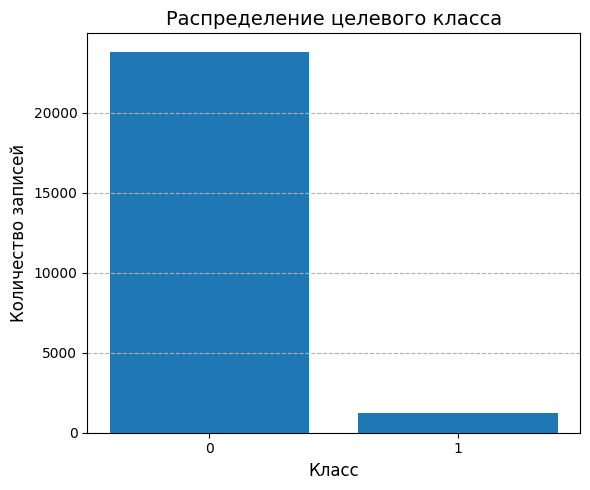

In [258]:
counts = df["target"].value_counts()
labels = counts.index.astype(str)
values = counts.values

plt.figure(figsize=(6, 5))
# Рисуем столбцы, можно задать свои цвета
plt.bar(labels, values)

plt.title("Распределение целевого класса", fontsize=14)
plt.xlabel("Класс", fontsize=12)
plt.ylabel("Количество записей", fontsize=12)

plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

In [259]:
target_corr = df.drop("id", axis=1).corr()["target"].abs().sort_values(ascending=False)
print("Топ-10 признаков, коррелирующих с таргетом:")
print(target_corr.head(11))

Топ-10 признаков, коррелирующих с таргетом:
target    1.000000
f53       0.221280
f58       0.178578
f47       0.164823
f13       0.143905
f57       0.138601
f36       0.113409
f41       0.105467
f38       0.104171
f16       0.092415
f11       0.088233
Name: target, dtype: float64


### 1.1. Анализ данных и стратегия валидации

**Наблюдения по Dataset-04:**
1.  **Размерность:** 25,000 объектов, 60 признаков
2.  **Дисбаланс классов:** Это ключевая особенность датасета, распределение примерно 95/5, анализ и построение моделей требует корректировок
3.  **Вывод по метрикам:**
    - `Accuracy` бесполезна как основная метрика. Константная модель (всегда предсказывать 0) даст accuracy ~95%, но будет бесполезна (увидим на примере dummyClassifier)
    - Основные метрики для сравнения: **ROC-AUC** и **F1-score**, а так же **Recall**

**Стратегия валидации:**
Из-за дисбаланса критически важно использовать **стратификацию** (`stratify=y`) при разбиении на train/test и внутри кросс-валидации, чтобы доля редкого класса (1) была одинаковой во всех фолдах, а в моделях делать балансировку при помощи соответвующих параметров

Перейдём к Train/Test сплит. Очень важно сохранить баланс классов в итоговых выборках, так что будем использовать stratify=y, а так же будем использовать контантный random_state для воспроизводимости эксперимента

In [260]:
X = df.drop(["id", "target"], axis=1)
y = df["target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [261]:
results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

dummyClass = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummyClass.fit(X_train, y_train)

results.append(
    evaluate_on_test(dummyClass, X_test, y_test, "DummyClassifier(most_freq)")
)
best_models["DummyClassifier(most_freq)"] = dummyClass

LogReg = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("LogReg", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ]
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Подбираем C (обратная сила регуляризации): меньше C -> сильнее регуляризация -> проще модель.
LogReg_grid = {
    "LogReg__C": [0.1, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0],
    "LogReg__penalty": ["l2"],
    "LogReg__solver": ["lbfgs"],
}

LogReg_search = GridSearchCV(
    LogReg,
    LogReg_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)


In [262]:
LogReg_search.fit(X_train, y_train)
best_LogReg = LogReg_search.best_estimator_
best_models["LogReg(scaled)"] = best_LogReg

search_summaries["LogReg(scaled)"] = {
    "best_params": LogReg_search.best_params_,
    "best_cv_roс_aug": float(LogReg_search.best_score_),
}

results.append(evaluate_on_test(best_LogReg, X_test, y_test, "LogReg(scaled)"))


search_summaries["LogReg(scaled)"]

{'best_params': {'LogReg__C': 0.1,
  'LogReg__penalty': 'l2',
  'LogReg__solver': 'lbfgs'},
 'best_cv_roс_aug': 0.8216090458867582}

Мы обучили два бейзлайна:
1.  **DummyClassifier (most_frequent):**
    - Accuracy ~95% (совпадает с долей мажоритарного класса).
    - ROC-AUC = 0.5 (случайное гадание).
    - F1 = 0.0 (так как Positive class ни разу не был предсказан).
    - *Вывод:* Модель подтверждает дисбаланс, но не несет пользы.

2.  **LogisticRegression (Scaled):**
    - ROC-AUC ~0.835. Это уже неплохой результат, указывающий на наличие линейных зависимостей в данных.
    - Однако, F1 ~0.43 и Recall ~0.28 говорят о том, что линейная модель плохо "вылавливает" редкий класс.

Можно предположить, что более сложные нелинейные модели (деревья и ансамбли) должны справиться лучше с разделением классов в многомерном пространстве, особенно при дисбалансе классов, давайте это проверим

### 3. Эксперименты с моделями (Trees & Ensembles)

Сравним три подхода к нелинейному моделированию:

1.  **Decision Tree:**
    - Одиночное дерево. Склонно к переобучению.
    - *Тюнинг:* Ограничиваем глубину (`max_depth`) и минимальное число объектов в листе (`min_samples_leaf`), используем балансировку весов классов (`class_weight='balanced'`), чтобы дерево обращало внимание на редкий класс.

2.  **Random Forest (Bagging):**
    - Ансамбль независимых деревьев. Снижает разброс (variance) одиночного дерева.
    - *Тюнинг:* Также используем `class_weight`, варьируем глубину.

3.  **Boosting (AdaBoost):**
    - Последовательное построение моделей, где каждая следующая исправляет ошибки предыдущей.
    - *Тюнинг:* Скорость обучения (`learning_rate`) и сложность базовых эстиматоров.

4.  **Stacking (Ensemble):**
    - Мета-модель (LogReg), которая обучается на предсказаниях лучших версий предыдущих моделей.

In [263]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=2,
        refit=True,
        return_train_score=True,
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [264]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [3, 5, 8, 12],
    "min_samples_leaf": [5, 10, 20, 50],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
    "class_weight": ["balanced", None],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

Fitting 5 folds for each of 128 candidates, totalling 640 fits


{'best_params': {'ccp_alpha': 0.0,
  'class_weight': 'balanced',
  'max_depth': 5,
  'min_samples_leaf': 50},
 'best_cv_roc_auc': 0.8203727414428694}

In [265]:
rf = RandomForestClassifier(
    n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, oob_score=False
)

rf_grid = {
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [5, 20],
    "max_features": ["sqrt"],
    "class_weight": ["balanced", "balanced_subsample"],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'best_params': {'class_weight': 'balanced_subsample',
  'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 5},
 'best_cv_roc_auc': 0.8958703545193115}

In [266]:
base_estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)

ab = AdaBoostClassifier(
    estimator=base_estimator, n_estimators=100, random_state=RANDOM_STATE
)

ab_grid = {"learning_rate": [0.05, 0.1, 0.5, 1.0], "estimator__max_depth": [1, 2]}

ab_search = run_search("AdaBoost", ab, ab_grid)
search_summaries["AdaBoost"]


Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("ab", best_models["AdaBoost"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    verbose=2,
    passthrough=False,
)

# Стекинг обычно имеет мало “ручек”, поэтому без GridSearch – просто честная оценка
stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

{"note": "stacking fitted"}

{'note': 'stacking fitted'}

In [ ]:
df_results = pd.DataFrame(results)

df_results_sorted = df_results.copy()
df_results_sorted["roc_auc_sort"] = df_results_sorted["roc_auc"].fillna(-1.0)
df_results_sorted = df_results_sorted.sort_values(
    ["roc_auc_sort", "f1", "recall"], ascending=False
).drop(columns=["roc_auc_sort"])

df_results_sorted

,f1,recall,accuracy,roc_auc,model
3,0.707692,0.560976,0.9772,0.886052,RandomForest
5,0.743529,0.642276,0.9782,0.885441,Stacking
4,0.544928,0.382114,0.9686,0.874669,AdaBoost
1,0.428571,0.280488,0.9632,0.834512,LogReg(scaled)
2,0.364364,0.739837,0.8730,0.832923,DecisionTree
0,0.000000,0.000000,0.9508,0.500000,DummyClassifier(most_freq)


### 4. Сравнение результатов

**Лидерборд:**
1.  **Random Forest** показал лучший результат по ROC-AUC (~0.886) и сбалансированный F1 (~0.71). Это типично для табличных данных с шумом и нелинейностями — бэггинг отлично справляется с задачей.
2.  **Stacking** показал результат очень близкий к RF (ROC-AUC ~0.885), но с более высоким Recall и F1. Это говорит о том, что комбинация моделей (особенно с добавлением LogReg и Boosting) помогла лучше охватить пространство признаков.
3.  **AdaBoost** и **DecisionTree** уступили лидерам. Одиночное дерево слишком простое, а AdaBoost в данной конфигурации (на простых пнях) не смог извлечь максимум из данных.
4.  **LogisticRegression** оказалась слабее ансамблей, что подтверждает нелинейную природу зависимостей в данных.

**Вывод:** Для финальной диагностики и внедрения выбираем **Random Forest** (или Stacking, если важен именно Recall/F1, но RF проще в интерпретации и поддержке).

In [ ]:
print(results[0].keys())

dict_keys(['f1', 'recall', 'accuracy', 'roc_auc', 'model'])


In [ ]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_results_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [ ]:
best_row = df_results_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('RandomForest',
 {'f1': 0.7076923076923077,
  'recall': 0.5609756097560976,
  'accuracy': 0.9772,
  'roc_auc': 0.8860523102496485,
  'model': 'RandomForest'})

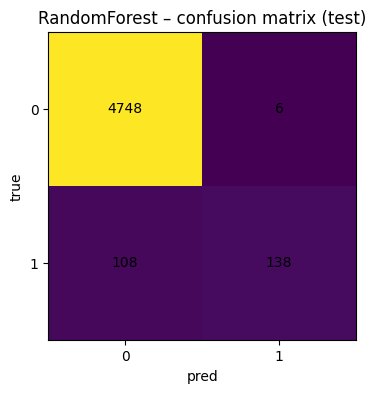

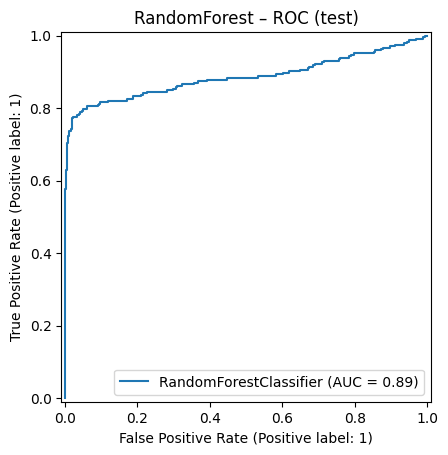

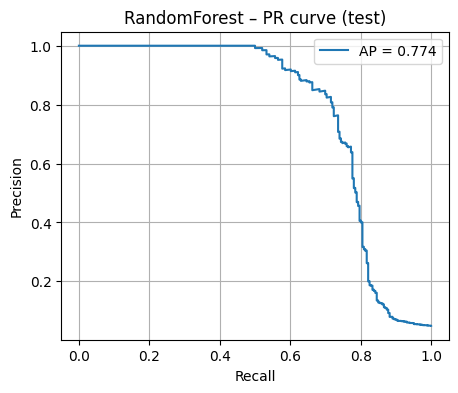

In [275]:
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")
plot_pr_curve(y_test, y_score, "RandomForest – PR curve (test)")

In [ ]:
real_best_row = df_results_sorted.iloc[1]
real_best_label = real_best_row["model"]
real_best_model = best_models[real_best_label]

real_best_label, real_best_row.to_dict()

('Stacking',
 {'f1': 0.7435294117647059,
  'recall': 0.6422764227642277,
  'accuracy': 0.9782,
  'roc_auc': 0.8854409295039523,
  'model': 'Stacking'})

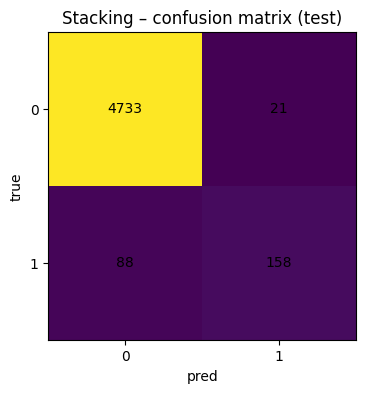

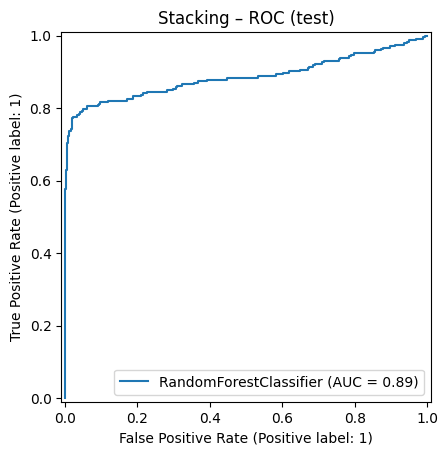

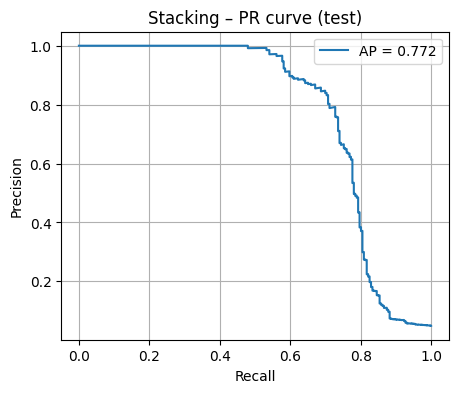

In [278]:
y_pred = real_best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{real_best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{real_best_label} – ROC (test)")
y_score = real_best_model.predict_proba(X_test)[:, 1]
plot_pr_curve(y_test, y_score, "Stacking – PR curve (test)")

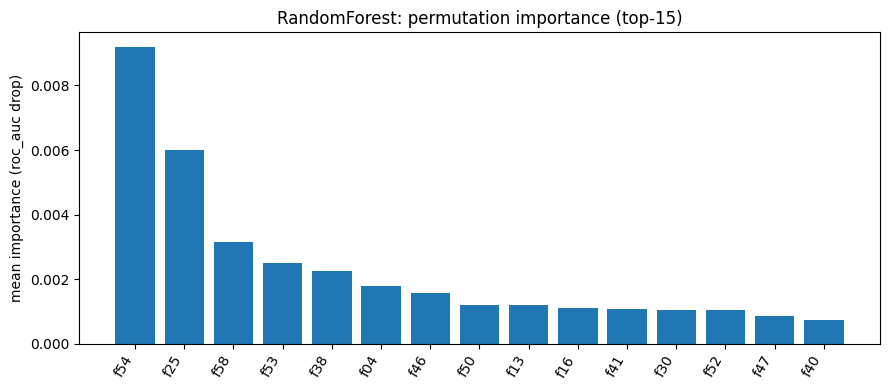

In [ ]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "f1"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [X_train.columns.tolist()[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()
     

### 5. Интерпретация лучшей модели (Random Forest)

1.  **Confusion Matrix:**
    - Модель хорошо определяет мажоритарный класс (0).
    - Ошибки False Negative (пропуск класса 1) составляют значимую часть ошибок. Это ожидаемо при таком дисбалансе, но Recall ~0.56 намного лучше, чем у линейной регрессии.

2.  **Permutation Importance:**
    - График показывает, какие признаки вносят наибольший вклад в качество модели (по падению метрики при их перемешивании).
    - Мы видим явного лидера (`f54`).
    - Интересно, что в таблице самый коррелирующий признак с таргетом распологается лишь на **3ем месте**.

Сохраним информацию о лучшей моделе

In [ ]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json
